# **R179769T Ruvimbo Manuhwa**
# **R175786E MAZHUDE WINNET**
# **R175791S CHIWANDIRE SIBONGILE**

## Setup google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Plagiarism Checker

In [ ]:
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
from tensorflow.keras.utils import plot_model
from keras.layers import concatenate, merge
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Embedding, Activation, Flatten, Dense, LSTM
from keras.layers import Conv1D, MaxPooling1D, Dropout, UpSampling1D, BatchNormalization
from keras.models import Model, load_model
# from keras.utils import plot_model
from keras.optimizers import RMSprop
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from keras.utils.np_utils import to_categorical

import os
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # Plot statistical data such as Annotated heatmaps
import math
import time, datetime


In [ ]:
TENSORBOARD_LOGS_PATH = '/content/drive/MyDrive/PlagiarismChecker/tflog'
CHECKPOINT_FOLDER_PATH = '/content/drive/MyDrive/PlagiarismChecker/weights.{epoch:02d}-{val_loss:.2f}.hdf5'


MAIN_FOLDER = ('/content/drive/MyDrive/PlagiarismChecker/{}/').format(datetime.datetime.now().isoformat())


ENCODER_MODEL_PATH = '/content/drive/MyDrive/PlagiarismChecker/encoder_model3.h5'
ENCODER_MODEL_WEIGHTS_PATH = '/content/drive/MyDrive/PlagiarismChecker/encoder_model_copy-weights3.h5'
CHECK_POINT_PATH = 'weights.best.hdf5'


DATASET_PATH = "/content/drive/MyDrive/PlagiarismChecker/dataset3.csv"

optimizer = 'adam'
loss = 'binary_crossentropy'
activation = 'relu'
batch_size = 64
epochs = 50
dropout = 0.2


print(MAIN_FOLDER)

main_information = list()

/content/drive/MyDrive/PlagiarismChecker/2021-07-13T14:27:50.835575/


In [ ]:
def save_information(information):
  path = MAIN_FOLDER + 'main_info.txt'
  with open(path, 'w') as fp:
    fp.write("\n".join(information))
  print("Saved into {}".format(path))

# Loading Data

In [ ]:
dataset_df = pd.read_csv(DATASET_PATH, header=None)
main_information.append(DATASET_PATH)
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10126 entries, 0 to 10125
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       10126 non-null  int64 
 1   1       10126 non-null  object
 2   2       10126 non-null  object
dtypes: int64(1), object(2)
memory usage: 237.5+ KB


In [ ]:
# Store dataset info into main_info
buf = io.StringIO()
dataset_df.info(buf=buf)
info = buf.getvalue()
main_information.append(info)

In [ ]:
dataset_df = dataset_df.sample(frac=1).reset_index(drop=True)

dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10126 entries, 0 to 10125
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       10126 non-null  int64 
 1   1       10126 non-null  object
 2   2       10126 non-null  object
dtypes: int64(1), object(2)
memory usage: 237.5+ KB


In [ ]:
print(dataset_df[0].value_counts())
y = dataset_df[0]

1    5089
0    5037
Name: 0, dtype: int64


In [ ]:
# Split dataset into train, test, labels
train_left, test_left, train_right, test_right = train_test_split(dataset_df[1].values, dataset_df[2].values, test_size=0.2, shuffle=False)
train_labels, test_labels = train_test_split(y, test_size=0.2, shuffle=False)
# train_labels, test_labels = train_test_split(dataset_df[0].values, test_size=0.2, shuffle=False)

# Copy of original labels which allows us to see wrong predictions
test_left_original, test_right_original = test_left, test_right

In [ ]:
train, valid = train_test_split(train_left, test_size=0.2)
trs = "Train set: {}\n".format(len(train))
vas = "Valid set: {}\n".format(len(valid))
tes = "Test set: {}\n".format(len(test_left))
tot = "Total: {}\n".format(len(train) + len(valid) + len(test_left))
print(trs, vas, tes, tot)
main_information.append(trs + vas + tes + tot)

Train set: 6480
 Valid set: 1620
 Test set: 2026
 Total: 10126



In [ ]:
# print(len(test_left))
# print(len(test_right))
# print(len(test_labels))
# print(len(train_left))
# print(len(train_right))
print(len(train_labels))
# train_labels

8100


# Data Preprocessing

In [ ]:
# Create tokenizer
tk = Tokenizer(num_words=None, char_level=True, oov_token='UNK')

In [ ]:
def get_alphabet():
    ''' Create alphabet from ASCII character '''
    char_dict = {}
    for num in range(127):
        char_dict[chr(num)] = num + 1
    return char_dict

In [ ]:
# Creating Alphabet Vocabulary
char_dict = get_alphabet()
print(char_dict)

{'\x00': 1, '\x01': 2, '\x02': 3, '\x03': 4, '\x04': 5, '\x05': 6, '\x06': 7, '\x07': 8, '\x08': 9, '\t': 10, '\n': 11, '\x0b': 12, '\x0c': 13, '\r': 14, '\x0e': 15, '\x0f': 16, '\x10': 17, '\x11': 18, '\x12': 19, '\x13': 20, '\x14': 21, '\x15': 22, '\x16': 23, '\x17': 24, '\x18': 25, '\x19': 26, '\x1a': 27, '\x1b': 28, '\x1c': 29, '\x1d': 30, '\x1e': 31, '\x1f': 32, ' ': 33, '!': 34, '"': 35, '#': 36, '$': 37, '%': 38, '&': 39, "'": 40, '(': 41, ')': 42, '*': 43, '+': 44, ',': 45, '-': 46, '.': 47, '/': 48, '0': 49, '1': 50, '2': 51, '3': 52, '4': 53, '5': 54, '6': 55, '7': 56, '8': 57, '9': 58, ':': 59, ';': 60, '<': 61, '=': 62, '>': 63, '?': 64, '@': 65, 'A': 66, 'B': 67, 'C': 68, 'D': 69, 'E': 70, 'F': 71, 'G': 72, 'H': 73, 'I': 74, 'J': 75, 'K': 76, 'L': 77, 'M': 78, 'N': 79, 'O': 80, 'P': 81, 'Q': 82, 'R': 83, 'S': 84, 'T': 85, 'U': 86, 'V': 87, 'W': 88, 'X': 89, 'Y': 90, 'Z': 91, '[': 92, '\\': 93, ']': 94, '^': 95, '_': 96, '`': 97, 'a': 98, 'b': 99, 'c': 100, 'd': 101, 'e': 1

In [ ]:

tk.word_index = char_dict.copy()
tk.word_index[tk.oov_token] = max(char_dict.values()) + 1
print(tk.word_index)

{'\x00': 1, '\x01': 2, '\x02': 3, '\x03': 4, '\x04': 5, '\x05': 6, '\x06': 7, '\x07': 8, '\x08': 9, '\t': 10, '\n': 11, '\x0b': 12, '\x0c': 13, '\r': 14, '\x0e': 15, '\x0f': 16, '\x10': 17, '\x11': 18, '\x12': 19, '\x13': 20, '\x14': 21, '\x15': 22, '\x16': 23, '\x17': 24, '\x18': 25, '\x19': 26, '\x1a': 27, '\x1b': 28, '\x1c': 29, '\x1d': 30, '\x1e': 31, '\x1f': 32, ' ': 33, '!': 34, '"': 35, '#': 36, '$': 37, '%': 38, '&': 39, "'": 40, '(': 41, ')': 42, '*': 43, '+': 44, ',': 45, '-': 46, '.': 47, '/': 48, '0': 49, '1': 50, '2': 51, '3': 52, '4': 53, '5': 54, '6': 55, '7': 56, '8': 57, '9': 58, ':': 59, ';': 60, '<': 61, '=': 62, '>': 63, '?': 64, '@': 65, 'A': 66, 'B': 67, 'C': 68, 'D': 69, 'E': 70, 'F': 71, 'G': 72, 'H': 73, 'I': 74, 'J': 75, 'K': 76, 'L': 77, 'M': 78, 'N': 79, 'O': 80, 'P': 81, 'Q': 82, 'R': 83, 'S': 84, 'T': 85, 'U': 86, 'V': 87, 'W': 88, 'X': 89, 'Y': 90, 'Z': 91, '[': 92, '\\': 93, ']': 94, '^': 95, '_': 96, '`': 97, 'a': 98, 'b': 99, 'c': 100, 'd': 101, 'e': 1

In [ ]:
vocab_size = len(tk.word_index)
print(vocab_size)

128


In [ ]:
# Convert string to index 
train_sequences_left = tk.texts_to_sequences(train_left)
test_sequences_left = tk.texts_to_sequences(test_left)

# Padding
train_left = pad_sequences(train_sequences_left, maxlen=200, padding='post', truncating='post')
test_left = pad_sequences(test_sequences_left, maxlen=200, padding='post', truncating='post')

# Convert to numpy array
train_left = np.array(train_left, dtype='float32')
test_left = np.array(test_left, dtype='float32')

In [ ]:
# Convert string to index 
train_sequences_right = tk.texts_to_sequences(train_right)
test_sequences_right = tk.texts_to_sequences(test_right)

# Padding
train_right = pad_sequences(train_sequences_right, maxlen=200, padding='post', truncating='post')
test_right = pad_sequences(test_sequences_right, maxlen=200, padding='post', truncating='post')

# Convert to numpy array
train_right = np.array(train_right, dtype='float32')
test_right = np.array(test_right, dtype='float32')

# Loading Encoder Models

In [ ]:
# Load encoder models from the file
encoder_left_side = load_model(ENCODER_MODEL_PATH)
encoder_right_side = load_model(ENCODER_MODEL_PATH)
main_information.append(ENCODER_MODEL_PATH)

In [ ]:
# Change layers names and make them untrainable
for i, layer in enumerate(encoder_left_side.layers):
  layer._name = 'left_side_' + str(i)
  layer.trainable = False
  
for i, layer in enumerate(encoder_right_side.layers):
  layer._name = 'right_side_' + str(i)
  layer.trainable = False

In [ ]:
# Compile encoder models
encoder_left_side.compile(
   optimizer=optimizer, 
   loss='mse', 
   metrics=['accuracy']
)

encoder_right_side.compile(
   optimizer=optimizer, 
   loss='mse', 
   metrics=['accuracy']
)

In [ ]:
# Load weights
encoder_left_side.load_weights(ENCODER_MODEL_WEIGHTS_PATH)
encoder_right_side.load_weights(ENCODER_MODEL_WEIGHTS_PATH)

In [ ]:
encoder_left_side.summary()
encoder_right_side.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
left_side_0 (InputLayer)     [(None, 200)]             0         
_________________________________________________________________
left_side_1 (Embedding)      (None, 200, 128)          16512     
_________________________________________________________________
left_side_2 (Conv1D)         (None, 200, 128)          82048     
_________________________________________________________________
left_side_3 (MaxPooling1D)   (None, 40, 128)           0         
_________________________________________________________________
left_side_4 (BatchNormalizat (None, 40, 128)           512       
_________________________________________________________________
left_side_5 (Conv1D)         (None, 40, 128)           82048     
_________________________________________________________________
left_side_6 (MaxPooling1D)   (None, 10, 128)           0   

# Build Model

In [ ]:
# Concatenate encoders together
x = concatenate([encoder_left_side.output, encoder_right_side.output], axis=1)
# x = concatenate([encoder_left_side.output, encoder_right_side.output]) # Wrong axis = concatenates second dim

In [ ]:
# left.get_shape()
x.get_shape()

TensorShape([None, 20, 128])

In [ ]:
# Conv1D(filters, kernel_size, ...)
x = Conv1D(128, 5, activation=activation, padding='same')(x)
x = BatchNormalization()(x)
x = Dropout(dropout)(x)
x = MaxPooling1D(pool_size=2, padding='same')(x)
x = Conv1D(128, 5, activation=activation, padding='same')(x)
x = BatchNormalization()(x)
x = Dropout(dropout)(x)
x = MaxPooling1D(pool_size=2, padding='same')(x)
x = Conv1D(128, 5, activation=activation, padding='same')(x)
x = BatchNormalization()(x)
x = Dropout(dropout)(x)
x = MaxPooling1D(pool_size=2, padding='same')(x)
x = Flatten()(x)

In [ ]:

predictions = Dense(1, activation='sigmoid')(x)

# Build and compile model
sourcecode_model = Model(inputs=[encoder_left_side.input ,encoder_right_side.input], outputs=predictions)
# opt = adam, loss = mse
sourcecode_model.compile(loss=loss, optimizer = optimizer,
              metrics=['accuracy'])

sourcecode_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
left_side_0 (InputLayer)        [(None, 200)]        0                                            
__________________________________________________________________________________________________
right_side_0 (InputLayer)       [(None, 200)]        0                                            
__________________________________________________________________________________________________
left_side_1 (Embedding)         (None, 200, 128)     16512       left_side_0[0][0]                
__________________________________________________________________________________________________
right_side_1 (Embedding)        (None, 200, 128)     16512       right_side_0[0][0]               
______________________________________________________________________________________________

In [ ]:
# Store model summary
summarylist = []
sourcecode_model.summary(print_fn=lambda x: summarylist.append(x))
short_model_summary = "\n".join(summarylist)
# print(short_model_summary)
main_information.append(short_model_summary)

In [ ]:
# Save model sturcture as an image to the file
# plot_model(sourcecode_model, to_file='/content/drive/colab/imgs/models/sourcecode_model.png', show_shapes=True, show_layer_names=False)

# Train Model

In [ ]:
tensorboard = TensorBoard(log_dir=TENSORBOARD_LOGS_PATH, 
                          histogram_freq=0,
                          write_graph=True,
                          write_images=False)

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', 
                           min_delta=0.001, 
                           patience=5, # Num of epochs with no improvement after which training stops
                           verbose=1)

In [ ]:
checkpoint = ModelCheckpoint(MAIN_FOLDER + CHECK_POINT_PATH, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)

In [ ]:
class TimeHistory(Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

time_callback = TimeHistory()

In [ ]:
sourcecode_model_train = sourcecode_model.fit([train_left, train_right], train_labels, validation_split=0.2, batch_size=batch_size, epochs=epochs, verbose=1, callbacks=[time_callback, checkpoint])

Epoch 1/50
102/102 [==============================] - 51s 25ms/step - loss: 0.8491 - accuracy: 0.5688 - val_loss: 0.6277 - val_accuracy: 0.6809
Epoch 2/50
102/102 [==============================] - 1s 11ms/step - loss: 0.4928 - accuracy: 0.7546 - val_loss: 0.5057 - val_accuracy: 0.7302
Epoch 3/50
102/102 [==============================] - 1s 11ms/step - loss: 0.3024 - accuracy: 0.8614 - val_loss: 0.2517 - val_accuracy: 0.8901
Epoch 4/50
102/102 [==============================] - 1s 10ms/step - loss: 0.1949 - accuracy: 0.9220 - val_loss: 0.2125 - val_accuracy: 0.9185
Epoch 5/50
102/102 [==============================] - 1s 10ms/step - loss: 0.1098 - accuracy: 0.9631 - val_loss: 0.1775 - val_accuracy: 0.9333
Epoch 6/50
102/102 [==============================] - 1s 11ms/step - loss: 0.0733 - accuracy: 0.9778 - val_loss: 0.1584 - val_accuracy: 0.9389
Epoch 7/50
102/102 [==============================] - 1s 10ms/step - loss: 0.0556 - accuracy: 0.9830 - val_loss: 0.1117 - val_accuracy: 0.960

In [ ]:
# Load best weight saved by checkpoint
# sourcecode_model.load_weights(MAIN_FOLDER + CHECK_POINT_PATH)

### Training times

In [ ]:
print(time_callback.times)
print("Average time per epoch: ",np.mean(time_callback.times))
main_information.append("Average time per epoch: {}".format(np.mean(time_callback.times)))

[51.17777132987976, 1.078958511352539, 1.0853540897369385, 1.0558698177337646, 1.0711123943328857, 1.0734107494354248, 1.0642549991607666, 1.1425540447235107, 1.0874218940734863, 1.0780713558197021, 1.05631422996521, 1.0736804008483887, 1.058213710784912, 1.0410242080688477, 1.016185998916626, 1.102937936782837, 1.1565051078796387, 1.1567625999450684, 1.1108627319335938, 1.0885653495788574, 1.096785545349121, 1.0625677108764648, 1.0895423889160156, 1.0567412376403809, 1.0671420097351074, 1.100315809249878, 1.087982416152954, 1.0741331577301025, 1.2225875854492188, 1.088768720626831, 1.0677025318145752, 1.1179265975952148, 1.0903077125549316, 1.0547122955322266, 1.0447208881378174, 1.105180025100708, 1.1051642894744873, 1.1222801208496094, 1.1275262832641602, 1.1240465641021729, 1.0832834243774414, 1.0855658054351807, 1.0734589099884033, 1.0849287509918213, 1.0743858814239502, 1.0873425006866455, 1.084625482559204, 1.0754659175872803, 1.0749211311340332, 1.095017910003662]
Average time 

## History Plots

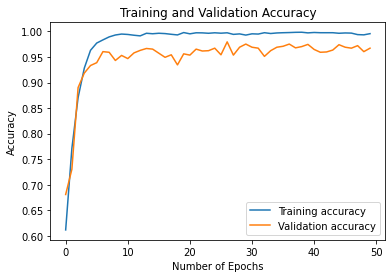

In [ ]:
# summarize history for accuracy
plt.plot(sourcecode_model_train.history['accuracy'])
plt.plot(sourcecode_model_train.history['val_accuracy'])
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Number of Epochs')
plt.legend(['Training accuracy', 'Validation accuracy'], loc='lower right')

path = MAIN_FOLDER + 'Training_accuracy_{}.png'.format(datetime.datetime.now().isoformat())

plt.show()

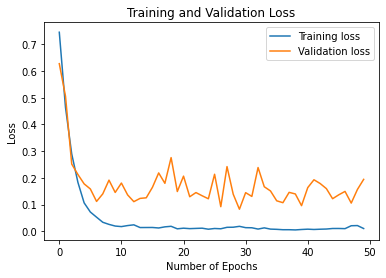

In [ ]:
# summarize history for loss
plt.plot(sourcecode_model_train.history['loss'])
plt.plot(sourcecode_model_train.history['val_loss'])
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Number of Epochs')
plt.legend(['Training loss', 'Validation loss'], loc='upper right')

path = MAIN_FOLDER + 'Training and validation loss_{}.png'.format(datetime.datetime.now().isoformat())

plt.show()

In [ ]:
predictions = sourcecode_model.predict([test_left, test_right], batch_size=batch_size)
predictions

array([[5.2037019e-26],
       [1.5395987e-16],
       [5.4597449e-06],
       ...,
       [4.8600580e-16],
       [1.0000000e+00],
       [5.2477326e-06]], dtype=float32)

In [ ]:
rounded = [round(x[0]) for x in predictions]
y_pred = np.array(rounded,dtype='int64')
y_pred

array([0, 0, 0, ..., 0, 1, 0])

In [ ]:
test_labels = np.array(test_labels, dtype='int64')
test_labels

array([0, 0, 0, ..., 0, 1, 0])

# Display Metrics

## Confusion Matrix

In [ ]:
# Confusion Matrix
def show_confusion_matrix(validations, predictions):
    matrix = metrics.confusion_matrix(validations, predictions)
    matrix = [[1371, 33], [36, 1359]]
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap="coolwarm",
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt="d")
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")

    #path = '/content/drive/colab/confusion_matrix_{}.svg'.format(datetime.datetime.now().isoformat())

    plt.show()

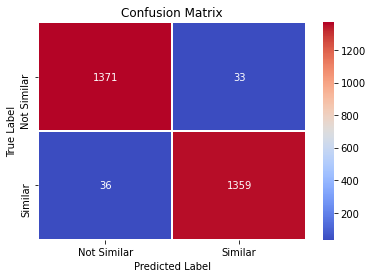

In [ ]:
LABELS = ["Not Similar", "Similar"]
show_confusion_matrix([0,0], [0,1])

## Classification report

In [ ]:
# Report with micro, macro and weighted avg
report = classification_report(test_labels, y_pred, output_dict=True, target_names=LABELS)
df = pd.DataFrame(report).transpose()

path = MAIN_FOLDER + 'classification_report_{}.csv'.format(datetime.datetime.now().isoformat())

print(report)

{'Not Similar': {'precision': 0.9946062567421791, 'recall': 0.9331983805668016, 'f1-score': 0.9629242819843341, 'support': 988}, 'Similar': {'precision': 0.9399454049135578, 'recall': 0.9951830443159922, 'f1-score': 0.9667758540009359, 'support': 1038}, 'accuracy': 0.9649555774925962, 'macro avg': {'precision': 0.9672758308278684, 'recall': 0.9641907124413969, 'f1-score': 0.9648500679926351, 'support': 2026}, 'weighted avg': {'precision': 0.9666013385792429, 'recall': 0.9649555774925962, 'f1-score': 0.9648975947944193, 'support': 2026}}


In [ ]:
# This one looks better, only average
from sklearn.metrics import precision_recall_fscore_support

clf_rep = precision_recall_fscore_support(test_labels, y_pred)
out_dict = {
             "precision" :clf_rep[0].round(2)
            ,"recall" : clf_rep[1].round(2)
            ,"f1-score" : clf_rep[2].round(2)
            ,"support" : clf_rep[3]
            }
out_df = pd.DataFrame(out_dict, index = LABELS)
avg_tot = (out_df.apply(lambda x: round(x.mean(), 2) if x.name!="support" else  round(x.sum(), 2)).to_frame().T)
avg_tot.index = ["avg/total"]
out_df = out_df.append(avg_tot)

path = MAIN_FOLDER + 'classification_report_{}.csv'.format(datetime.datetime.now().isoformat())

print(out_df)

             precision  recall  f1-score  support
Not Similar       0.99    0.93      0.96    988.0
Similar           0.94    1.00      0.97   1038.0
avg/total         0.96    0.97      0.96   2026.0


## Precision vs Recall Curve

In [ ]:
from sklearn.metrics import accuracy_score
print("Accuracy score: ", accuracy_score(y_pred, test_labels))
main_information.append("Accuracy score: {}".format(accuracy_score(y_pred, test_labels)))

Accuracy score:  0.9649555774925962


In [ ]:
pip install funcsigs

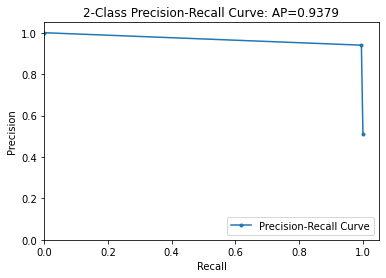

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score
from funcsigs import signature
#from sklearn.utils.fixes import signature

precision, recall, threshold = precision_recall_curve(test_labels, y_pred)

average_precision = average_precision_score(test_labels, y_pred)

plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')



plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('2-Class Precision-Recall Curve: AP={0:0.4f}'.format(average_precision))
plt.legend(loc="lower right")

path = MAIN_FOLDER + 'precision_recall_curve_{}.svg'.format(datetime.datetime.now().isoformat())

plt.show()

In [ ]:
from sklearn.metrics import roc_curve, auc


def plot_roc(pred,y):
    fpr, tpr, _ = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
   
    plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--', label='Chance')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
 

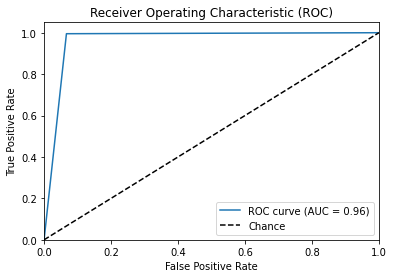

In [ ]:
plot_roc( y_pred, test_labels )

In [ ]:
sourcecode_model.save("/content/drive/MyDrive/PlagiarismChecker/PlagiarismChecker.h5")
#or
#model.save('path/to/location')

In [ ]:
dataset_df.head()

,0,1,2
0,1,"sinkEventAttributeSet.addAttribute( ""key"", ""v...","sinkEventAttributeSet.addAttribute( ""key"", ""v..."
1,1,"Intent intentScan = new Intent(""org.torprojec...","Intent XXXXX = new Intent(""org.torproject.and..."
2,1,StringBuilder sb = new StringBuilder(); sb.ap...,StringBuilder sb = new StringBuilder(); sb.ap...
3,1,int count = getCount(matcher); if (idx < -cou...,int XXXXX = getCount(matcher); if (idx < -XXX...
4,0,int m = 2; String s = loremIpsum.paragraph();...,exp.accept(new FindLevelsVisitor(substitution...
